Eigenvalues: [-1.10009090e+01  9.09015790e-04 -2.66666667e+00]
Center Eigenvector: [-0.70707464 -0.70713892  0.        ]


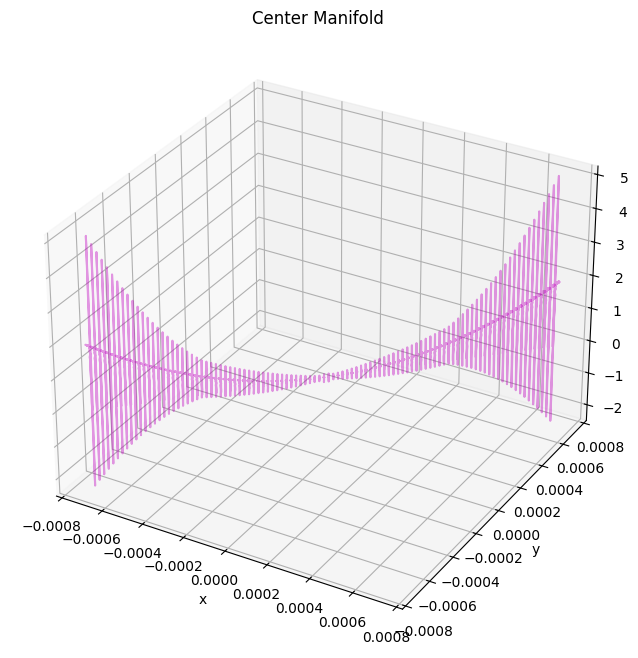

In [10]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pysindy as ps

# specific case of Lorenz system
def lorenz(t, xyz, sigma=10, beta=8/3, r=1.001):
    x, y, z = xyz
    dxdt = sigma * (y - x)
    dydt = r * x - y - x * z
    dzdt = -beta * z + x * y
    return [dxdt, dydt, dzdt]

# Jacobian for this system at origin
J = np.array([
        [-10, 10, 0],
        [1.001, -1, 0],
        [0, 0, -8/3]])

eigvals, eigvecs = np.linalg.eig(J)
print("Eigenvalues:", eigvals)

# let's find the center manifold
v_center = np.real(eigvecs[:, np.argmin(np.abs(eigvals))])
print("Center Eigenvector:", v_center)

# Generate initial conditions along the center eigenvector
deltas = np.linspace(-1e-3, 1e-3, 100)
initial_conditions = [delta * v_center for delta in deltas]

# Simulate trajectories from those initial conditions
t_span = (0, 20)
dt = 0.001
t_eval = np.arange(t_span[0], t_span[1], dt)

trajectories = []
for ic in initial_conditions:
    sol = solve_ivp(lorenz, t_span, ic, t_eval=t_eval, method='RK45')
    trajectories.append(sol.y.T)
# now trajectories is a list of 100 numpy arrays (since we plotted trajectories from 100 initial conditions)
# each with shape (total number of timesteps, 3), 3 being the dimensionality of the system

# Plot the trajectories
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
for traj in trajectories:
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='m', alpha=0.4)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Center Manifold')
plt.show()

(x0)' = -0.003 x0 + 0.004 x1 + 187503.032 x0 x2 + -171539.851 x1 x2 + -1171325757.599 x0^3 + 3481409972.055 x0^2 x1 + -3448575630.496 x0 x1^2 + 1138485394.738 x1^3
(x1)' = -0.002 x0 + 0.003 x1 + 137485796.479 x0^3 + -411104308.769 x0^2 x1 + 409753147.879 x0 x1^2 + -136134614.752 x1^3
(x2)' = -0.276 x2 + -1327.665 x0^2 + 2625.503 x0 x1 + -1297.702 x1^2


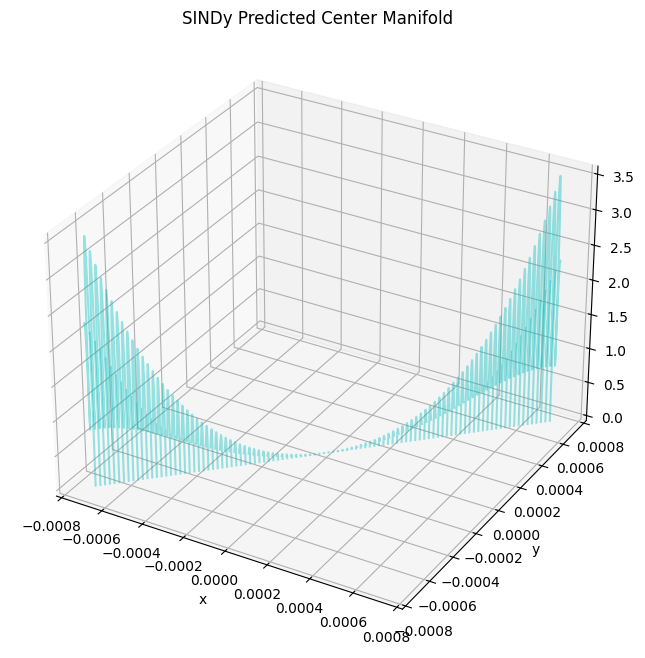

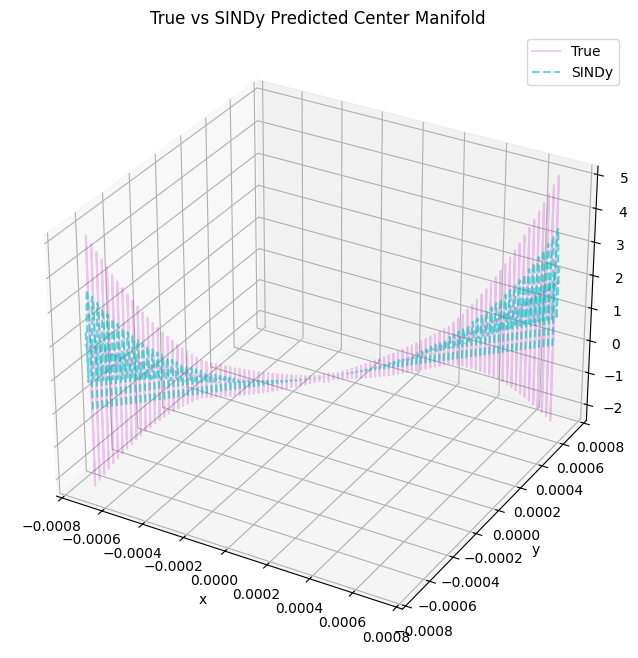

In [11]:
# Fit polynomial SINDy

optimizer = ps.STLSQ(threshold=1e-10)
lib = ps.PolynomialLibrary(degree=3, include_interaction=True, include_bias=False)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(trajectories, t=dt, multiple_trajectories=True)
model.print()

# Plot SINDy's predicted center manifold
sindy_trajecs = [model.simulate(ic, t_eval) for ic in initial_conditions]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
for traj in sindy_trajecs:
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='c', alpha=0.4)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('SINDy Predicted Center Manifold')
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
for traj in trajectories:
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='m', alpha=0.2, label='True' if 'True' not in ax.get_legend_handles_labels()[1] else "")
for traj in sindy_trajecs:
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='c', alpha=0.6, linestyle='--', label='SINDy' if 'SINDy' not in ax.get_legend_handles_labels()[1] else "")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('True vs SINDy Predicted Center Manifold')
ax.legend()
plt.show()